# Extracting Time-Series at Multiple Locations

## **Introduction**

This notebook shows how to use XArray to efficiently extract a time-series at multiple locations. You will also learn how to use XArray to construct a datacube from individual cloud-hosted files and sample data from it with minimal data transfer.

## Overview of the Task

We will take 12 individual Cloud-Optimized GeoTIFF (COG) files representing Soil Moisture for each month of a year, create a XArray Dataset from it and extract the soil moisture values for each month at multiple different locations.

**Input Layers**:
* `soil_moisture_202301.tif`, `soil_moisture_202302.tif` ...: Cloud-Optimized GeoTIFF files representing average soil misture for each month. This files were exported from TerraClimate data hosted on Google Earth Engine using. See [reference script](https://github.com/spatialthoughts/projects/blob/master/ee-python/export_climate_timeseries.ipynb)

**Output**:
* `soil_moisture.csv`: A CSV file containing extracted monthly soil moisture values at 3 different coordinates.

**Data Credit**:
- Abatzoglou, J.T., S.Z. Dobrowski, S.A. Parks, K.C. Hegewisch, 2018, Terraclimate, a high-resolution global dataset of monthly climate and climatic water balance from 1958-2015, Scientific Data 5:170191, doi:10.1038/sdata.2017.191


## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray

In [2]:
import datetime
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import zipfile

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

## Data Pre-Processing

In this example, we have a folder on Google Cloud Storage (GCS) has 12 Cloud-Optomized GeoTIFF files representing soil moisture for each month. The file URIs are as below

```
gs://spatialthoughts-public-data/terraclimate/soil_moisture_202301.tif
gs://spatialthoughts-public-data/terraclimate/soil_moisture_202302.tif
gs://spatialthoughts-public-data/terraclimate/soil_moisture_202303.tif
...
```

First we create an XArray Dataset from these individual files.

The files will be read using the GDAL library which allows reading cloud-hosted files directly. Files on Google Cloud Storage can be read using the `/vsigs/` prefix. Since our files are public, we specify the `GS_NO_SIGN_REQUEST=YES` option. For accessing data on private bucket, see the authentication options specified in [GDAL and Google Cloud Storage (GCS)
](https://spatialthoughts.com/2024/02/26/gdal-google-cloud-storage/).

In [4]:
os.environ['GS_NO_SIGN_REQUEST'] = 'YES'
prefix = '/vsigs/spatialthoughts-public-data/terraclimate/'

In [ ]:
# Create a list of URIs with /vgigs/ prefix
urls = []
for month in range(1, 13):
    image_id = f'soil_moisture_2023{month:02d}.tif'
    path = prefix + image_id
    urls.append(path)

urls

In [6]:
def path_to_datetimeindex(filepath):
  filename = os.path.basename(filepath)
  pattern = r'soil_moisture_(\d+).tif'
  match = re.search(pattern, filepath)
  if match:
      doy_value = match.group(1)
      timestamp = datetime.datetime.strptime(doy_value, '%Y%m')
      return timestamp
  else:
    print('Could not extract DOY from filename', filename)


timestamps = []
filepaths = []

for filepath in urls:
  timestamp = path_to_datetimeindex(filepath)
  filepaths.append(filepath)
  timestamps.append(timestamp)

unique_timestamps = sorted(set(timestamps))

In [ ]:
scenes = []

for timestamp in unique_timestamps:
  filename = f'soil_moisture_{timestamp.strftime('%Y%m')}.tif'
  filepath = prefix + filename
  print(f'Reading {filepath}')
  scene = rxr.open_rasterio(filepath, chunks={'x':512, 'y':512})
  scenes.append(scene)

In [8]:
time_var = xr.Variable('time', list(unique_timestamps))

time_series_scenes = xr.concat(scenes, dim=time_var)
time_series_scenes

<xarray.DataArray (time: 12, band: 1, y: 4321, x: 8641)> Size: 4GB
dask.array<concatenate, shape=(12, 1, 4321, 8641), dtype=float64, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 96B 2023-01-01 2023-02-01 ... 2023-12-01
  * band         (band) int64 8B 1
  * y            (y) float64 35kB 89.98 89.94 89.9 ... -89.94 -89.98 -90.02
  * x            (x) float64 69kB -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      soil

## Plotting the time-series

We extract the time-series at a specific X,Y coordinate.

In [9]:
time_series = time_series_scenes.interp(x=80.449, y=18.728)

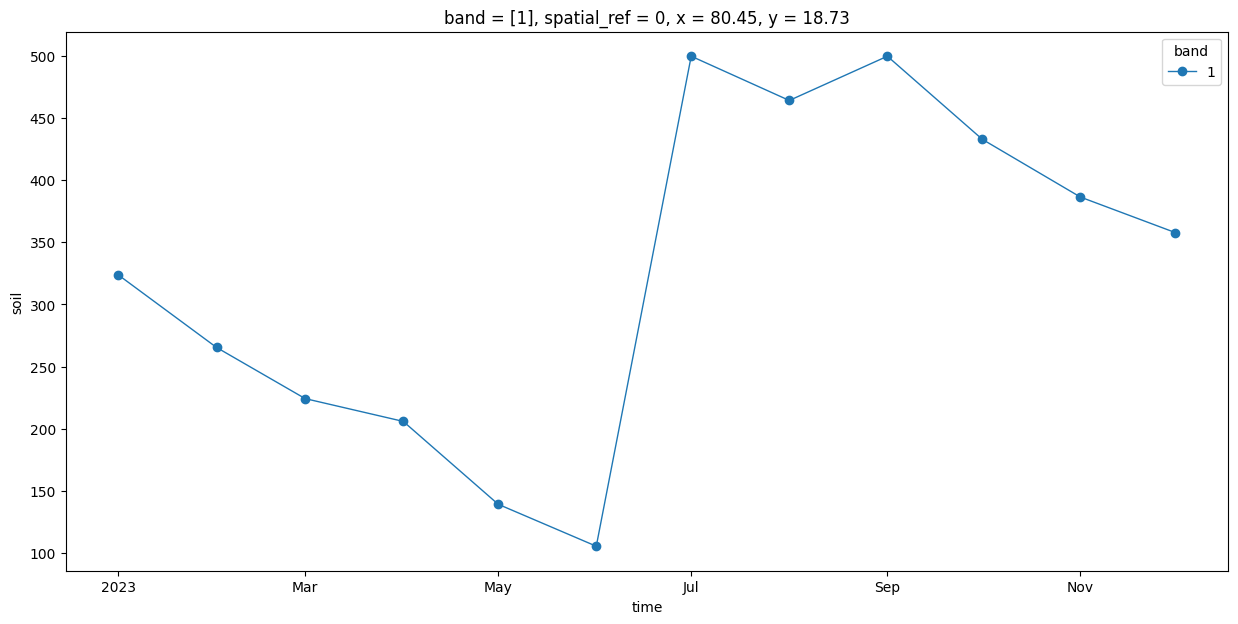

In [10]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(15, 7)
time_series.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()

## Extracting Time-Series at Multiple Locations

In [11]:
locations = [
    ('Location 1', 80.449, 18.728),
    ('Location 2', 79.1488, 15.2797),
    ('Location 3', 74.656, 25.144)
]

In [12]:
df = pd.DataFrame(locations, columns=['Name', 'x', 'y'])
geometry = gpd.points_from_xy(df.x, df.y)
gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=geometry)
gdf

,Name,x,y,geometry
0,Location 1,80.4490,18.7280,POINT (80.449 18.728)
1,Location 2,79.1488,15.2797,POINT (79.1488 15.2797)
2,Location 3,74.6560,25.1440,POINT (74.656 25.144)


In [13]:
x_coords = gdf.geometry.x.to_xarray()
y_coords = gdf.geometry.y.to_xarray()

In [14]:
sampled = time_series_scenes.sel(x=x_coords, y=y_coords, method='nearest')

Convert the sampled dataset to a Pandas Series.

In [20]:
sampled_df = sampled.to_series()
sampled_df.name = 'soil_moisture'
sampled_df = sampled_df.reset_index()
sampled_df.head()

,time,band,index,soil_moisture
0,2023-01-01,1,0,322.5
1,2023-01-01,1,1,33.5
2,2023-01-01,1,2,25.1
3,2023-02-01,1,0,264.4
4,2023-02-01,1,1,26.4


Add a formatted time column

In [21]:
sampled_df['formatted_time'] = sampled_df['time'].dt.strftime("%Y_%m")
sampled_df.head()

,time,band,index,soil_moisture,formatted_time
0,2023-01-01,1,0,322.5,2023_01
1,2023-01-01,1,1,33.5,2023_01
2,2023-01-01,1,2,25.1,2023_01
3,2023-02-01,1,0,264.4,2023_02
4,2023-02-01,1,1,26.4,2023_02


Convert this to a wide table, with each month's value as a column.

In [27]:
wide_df = sampled_df.pivot(index='index', columns='formatted_time', values='soil_moisture')
wide_df = wide_df.reset_index()
wide_df.iloc[:, :10]

formatted_time,index,2023_01,2023_02,2023_03,2023_04,2023_05,2023_06,2023_07,2023_08,2023_09
0,0,322.5,264.4,223.0,204.8,138.1,104.7,498.9,462.5,498.9
1,1,33.5,26.4,21.8,18.7,16.3,14.5,125.6,51.1,67.2
2,2,25.1,21.2,18.4,16.3,14.6,13.7,34.6,27.5,37.7


Merge the extracted value with the original data.

In [26]:
merged = pd.merge(gdf, wide_df, left_index=True, right_index=True)
merged.iloc[:, :10]

,Name,x,y,geometry,index,2023_01,2023_02,2023_03,2023_04,2023_05
0,Location 1,80.4490,18.7280,POINT (80.449 18.728),0,322.5,264.4,223.0,204.8,138.1
1,Location 2,79.1488,15.2797,POINT (79.1488 15.2797),1,33.5,26.4,21.8,18.7,16.3
2,Location 3,74.6560,25.1440,POINT (74.656 25.144),2,25.1,21.2,18.4,16.3,14.6


Finally, we save the sampled result to disk as a CSV.

In [19]:
output_filename = 'soil_moisture.csv'
output_path = os.path.join(output_folder, output_filename)
output_df = merged.drop(columns=['geometry', 'index'])
output_df.to_csv(output_path, index=False)

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>